# Data input and output

In this unit we discuss input and output,
or I/O for short. We focus exclusively on I/O
routines used to load and store data from files that are relevant
for numerical computation and data analysis.

## I/O with NumPy

### Loading text data

We have already encountered the most basic, and probably most frequently used
NumPy I/O routine, `np.loadtxt()`.
We often use files that store data
as text files containing character-separated values (CSV) since virtually
any application supports this data format.
The most important I/O functions to process text data are:

-   [`np.loadtxt()`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html):     load data from a text file.
-   [`np.genfromtxt()`](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html): 
    load data from a text file and handle missing data.
-   [`np.savetxt()`](https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html): 
    save a NumPy array to a text file.

There are a few other I/O functions in NumPy, for example to
write arrays as raw binary data.
We won't cover them here, but you can find them in the
[official documentation](https://numpy.org/doc/stable/reference/routines.io.html).

Imagine we have the following tabular data from [FRED](https://fred.stlouisfed.org/), where the first two rows
look as follows:

| Year |  GDP   |  CPI | UNRATE |
| ---- | ------ | ---- | ------ |
| 1948 | 2118.5 | 24.0 | 3.8    |
| 1949 | 2106.6 | 23.8 | 6.0    |

To load this CSV file as a NumPy array, we use `loadtxt()`. As in the previous unit, it is advantageous to globally set the path to the `data/` directory that can point either to the local directory or to the `data/` directory on GitHub.

In [1]:
# Uncomment this to use files in the local data/ directory
# DATA_PATH = '../data'

# Load data directly from GitHub
DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/MLFP-ECON5130/main/data'

In [2]:
import numpy as np


# relative path to CSV file
file = f'{DATA_PATH}/FRED.csv'

# load CSV
data = np.loadtxt(file, skiprows=1, delimiter=',')
data[:2]        # Display first two rows

array([[1948. , 2118.5,   24. ,    3.8],
       [1949. , 2106.6,   23.8,    6. ]])

The default settings will in many cases be appropriate to load
whatever CSV file we might have. However, we'll occasionally
want to specify the following arguments to override the defaults:

-   `delimiter`: Character used to separate individual fields (default: space).
-   `skiprows=n`: Skip the first `n` rows. For example, if the CSV file
    contains a header with variable names, `skiprows=1` needs to be
    specified as NumPy by default cannot process these names.
-   `dtype`: Enforce a particular data type for the resulting array.
-   `encoding`: Set the character encoding of the input data. This
    is usually not needed, but can be required to import data
    with non-latin characters that are not encoded using Unicode.

While `loadtxt()` is simple to use, it quickly reaches its limits
with more complex data sets.
For example, when we try to load our sample of universities with
`loadtxt()`, we get the following error:

In [3]:
import numpy as np

file = f'{DATA_PATH}/universities.csv'

# Try to load CSV data that contains strings
# This will result in an error!
data = np.loadtxt(file, delimiter=';', skiprows=1)

ValueError: could not convert string to float: '"University of Glasgow"'

This code fails for two reasons:

1.  The file contains strings and floats, and `loadtxt()` by default
    cannot load mixed data.
2.  There are missing values (empty fields), which `loadtxt()` cannot
    handle either.

We can address the first issue by creating a so-called
[structured array](https://numpy.org/doc/stable/user/basics.rec.html),
i.e., an array that contains fields with mixed data.
This is accomplished by constructing a special `dtype` object that
specifies the field names and their data types:

In [4]:
# Define names and data types for fields in CSV file
#   Data types are defined using two tokens:
#       1.  The main data type (U: unicode string, f: float, i: integer)
#       2.  The precision or field width
dtypes = np.dtype([('Institution', 'U30'),      # unicode string of length 30
                   ('Country', 'U20'),          # unicode string of length 20
                   ('Founded', 'i4'),           # integer, 4 bytes
                   ('Students', 'i4'),
                   ('Staff', 'i4'),
                   ('Admin', 'i4'),
                   ('Budget', 'f8'),            # float, 8 bytes
                   ('Russell', 'i1')])          # integer, 1 byte

data = np.loadtxt(file, delimiter=';', skiprows=1, dtype=dtypes)

ValueError: could not convert string to float: ''

However, this still fails because the of a few missing values.

We can get around this by using `genfromtxt()`, which is
more flexible and can also deal with missing data:

In [5]:
# load data using genfromtxt()
# We still need to specify the dtype defined above!
data = np.genfromtxt(file, delimiter=';', dtype=dtypes, encoding='utf8',
                     skip_header=1)

# Determine rows with missing data:
#   - missing integers are coded as -1
#   - missing floats are coded as np.nan
missing = (data['Staff'] < 0) | (data['Admin'] < 0) | np.isnan(data['Budget'])

# print rows with missing values
data[missing]

array([('"University of Strathclyde"', '"Scotland"', 1964, 22640,   -1, 3200,  304.4, 0),
       ('"University of Oxford"', '"England"', 1096, 24515, 7000,   -1, 2450. , 1),
       ('"University of Manchester"', '"England"', 2004, 40250, 3849,   -1, 1095.4, 1),
       ('"University of Birmingham"', '"England"', 1825, 35445, 4020,   -1,  673.8, 1),
       ('"University of Nottingham"', '"England"', 1798, 30798, 3495,   -1,  656.5, 1),
       ('"University of Stirling"', '"Scotland"', 1967,  9548,   -1, 1872,  113.3, 0),
       ('"Swansea University"', '"Wales"', 1920, 20620,   -1, 3290,    nan, 0)],
      dtype=[('Institution', '<U30'), ('Country', '<U20'), ('Founded', '<i4'), ('Students', '<i4'), ('Staff', '<i4'), ('Admin', '<i4'), ('Budget', '<f8'), ('Russell', 'i1')])

While the CSV file can now be processed without errors, you see that
NumPy does not remove the double quotes around strings such as the
university names.
Instead of trying to fix this, it is advisable to just use pandas to
load this kind of data which handles all these problems automatically.
We examine this alternative below.

### Saving data to text files

To save a NumPy array to a CSV file, there is a logical counterpart
to `np.loadtxt()` which is called `np.savetxt()`.

In [6]:
import numpy as np
import os.path
import tempfile

# Generate some random data on [0,1)
data = np.random.default_rng(123).random(size=(10, 5))

# create temporary directory
d = tempfile.TemporaryDirectory()

# path to CSV file
file = os.path.join(d.name, 'data.csv')

# Print destination file - this will be different each time
print(f'Saving CSV file to {file}')

# Write NumPy array to CSV file. The fmt argument specifies
# that data should be saved as floating-point using a
# field width of 8 characters and 5 decimal digits.
np.savetxt(file, data, delimiter=';', fmt='%8.5f')

Saving CSV file to /tmp/tmpdo45ybdi/data.csv


The above code creates a $10 \times 5$ matrix of random floats
and stores these in the file `data.csv` using 5 significant digits.

We store the destination file in a temporary directory which
we create as follows:

-   Because we cannot know in advance on which system this code
    is run (e.g. the operating system and directory layout),
    we cannot hard-code a file path.
-   Moreover, we do not know whether the code is run with write
    permissions in any particular folder.
-   We work around this issue by asking the Python runtime to
    create a writeable temporary directory *for the system
    where the code is being run*.
-   We use the routines in the 
    [`tempfile`](https://docs.python.org/3/library/tempfile.html) 
    module to create this temporary directory.

Of course, on your own computer you do not need to use a temporary
directory, but can instead use any directory where
your user has write permissions. For example, on Windows you
could use something along the lines of

    file = 'C:/Users/Path/to/file.txt'
    np.savetxt(file, data, delimiter=';', fmt='%8.5f')

You can even use relative paths. To store a file in the 
current working directory it is sufficient to just 
pass the file name:

    file = 'file.txt'
    np.savetxt(file, data, delimiter=';', fmt='%8.5f')

***
## I/O with pandas

Pandas's I/O routines are more powerful than those implemented in NumPy:

-   They support reading and writing numerous file formats.
-   They support heterogeneous data without having to specify
    the data type in advance.
-   They gracefully handle missing values.

For these reasons, it is often preferable to directly use pandas to
process data instead of NumPy.

The most important routines are:

-   [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), 
    [`to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html): 
    Read or write CSV text files
-   [`read_fwf()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_fwf.html): 
    Read data with fixed field widths, i.e. text data
    that does not use delimiters to separate fields.
-   [`read_excel()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html), 
    [`to_excel()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html): 
    Read or write Excel spreadsheets
-   [`read_stata()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_stata.html), 
    [`to_stata()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_stata.html): 
    Read or write Stata's `.dta` files.

For a complete list of I/O routines, see the [official documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

To illustrate, we repeat the above examples using pandas's
`read_csv()`. Since the FRED data contains only floating-point
data, the result is very similar to reading in a NumPy array.

In [7]:
import pandas as pd

# relative path to CSV file
file = f'{DATA_PATH}/FRED.csv'

df = pd.read_csv(file, sep=',')
df.head(2)          # Display the first 2 rows of data

,Year,GDP,CPI,UNRATE
0,1948,2118.5,24.0,3.8
1,1949,2106.6,23.8,6.0


The difference between NumPy and pandas become obvious when we
try to load our university data: this works out of the box,
without the need to specify any data types or to handle missing values:

In [8]:
import pandas as pd

# relative path to CSV file
file = f'{DATA_PATH}/universities.csv'

df = pd.read_csv(file, sep=';')
df.tail(3)      # show last 3 rows

,Institution,Country,Founded,Students,Staff,Admin,Budget,Russell
20,University of Stirling,Scotland,1967,9548,NaN,1872.0,113.3,0
21,Queen’s University Belfast,Northern Ireland,1810,18438,2414.0,1489.0,369.2,1
22,Swansea University,Wales,1920,20620,NaN,3290.0,NaN,0


Note that missing values are correctly converted to `np.nan` and
the double quotes surrounding strings are automatically removed!


Unlike NumPy, pandas can also process other popular data formats
such as MS Excel files (or OpenDocument spreadsheets):

In [9]:
import pandas as pd

# Excel file containing university data
file = f'{DATA_PATH}/universities.xlsx'

df = pd.read_excel(file, sheet_name='universities')
df.head(3)

,Institution,Country,Founded,Students,Staff,Admin,Budget,Russell
0,University of Glasgow,Scotland,1451,30805,2942.0,4003.0,626.5,1
1,University of Edinburgh,Scotland,1583,34275,4589.0,6107.0,1102.0,1
2,University of St Andrews,Scotland,1413,8984,1137.0,1576.0,251.2,0


The routine `read_excel()` takes the argument `sheet_name` to
specify the sheet that should be read.

-   Note that the Python package 
    [`openpyxl`](https://pypi.org/project/openpyxl/) 
    needs to be installed in order
    to read files from Excel 2003 and above.
-   To read older Excel files (`.xls`), you need the package 
    [`xlrd`](https://pypi.org/project/xlrd/).

Finally, we often encounter text files with fixed field widths,
since this is a commonly used format in older applications
(for example, fixed-width files are easy to create in Fortran).
To illustrate, the fixed-width variant of our FRED data looks like this:
```
 Year GDP    CPI  UNRATE
 1948 2118.5   24     3.8
 1949 2106.6 23.8       6
 1950 2289.5 24.1     5.2
 1951 2473.8   26     3.3
 1952 2574.9 26.6       3
```
You see that the column `Year` occupies the first 5
characters, the `GDP` column the next 7 characters, and so on.
To read such files, the width (i.e., the number of characters)
has to be explicitly specified:

In [10]:
import pandas as pd

# File name of FRED data, stored as fixed-width text
file = f'{DATA_PATH}/FRED-fixed.csv'

# field widths are passed as list to read_fwf()
df = pd.read_fwf(file, widths=[5, 7, 5, 8])
df.head(3)

,Year,GDP,CPI,UNRATE
0,1948,2118.5,24.0,3.8
1,1949,2106.6,23.8,6.0
2,1950,2289.5,24.1,5.2


Here the `widths` argument accepts a list that contains the
number of characters to be used for each field.

***
## Retrieving macroeconomic / financial data from the web

### Federal Reserve Economic Data (FRED)

[FRED](https://fred.stlouisfed.org/), provided by the Federal Reserve of St. Louis, is likely the most important macroeconomic online database (at least for US-centric data).
[`fredapi`](https://pypi.org/project/fredapi/) is a Python API for the FRED data which provides a wrapper for the FRED web service (see also the project's [GitHub page](https://github.com/mortada/fredapi)).

Before accessing FRED, you need to install `fredapi` into your Python environment as follows:
```
pip install --no-deps fredapi
```

*Important:*

- The `--no-deps` argument might be required for Anaconda users as otherwise the conda-provided versions of `numpy` and `pandas` could be overwritten.
- Anaconda users should _not_ use the `fredapi` package provided in `conda-forge` as that one is outdated and will not work.

To use FRED, you additional need an API key which can be requested at [https://fred.stlouisfed.org/docs/api/api_key.html](https://fred.stlouisfed.org/docs/api/api_key.html). Unlike with some other APIs we discuss below, it is not possible to make a request without a key. Once you have a key, you can specify it in several ways:

1. On your local machine, set the environment variable `FRED_API_KEY` to store the key and it will be picked up automatically. This only works if you run a Python environment locally.
2. Store it in a file and pass the file name when creating a `Fred` instance:

    ```
    from fredapi import Fred
    fred = Fred(api_key_file='path_to_file')
    ```

3. Pass the string containing the API key as a parameter:

    ```
    from fredapi import Fred
    fred = Fred(api_key='INSERT API KEY HERE')
    ```

The following code assumes that the `FRED_API_KEY` variable has been set up and might not work in your environment if that is not the case.

*Examples:*

In [ ]:
# Uncomment next line to install fredapi in your local or cloud-hosted Python environment (Binder or Google Colab)
#! pip install --no-deps fredapi

In order to retrieve any data, we first need to identify the series name. This is easiest done by searching for the data on [FRED](https://fred.stlouisfed.org/) using your browser and copying the series name, highlighted in red in the screenshot below.

![FRED series name](FRED_series_name.png)

For example, if we want to retrieve the [10-year real interest rate](https://fred.stlouisfed.org/series/REAINTRATREARAT10Y), the corresponding series name is `REAINTRATREARAT10Y`. The FRED web page contains additional useful information such as the time period for which the data is available, the data frequency (monthly, quarterly, annual) and whether it's seasonally adjusted.

To download and plot the 10-year real interest rate, we proceed as follows:

In [2]:
from fredapi import Fred

# Create instance assuming API key is stored as environment variable
fred = Fred()

# or specify API key directly
# fred = Fred(api_key='INSERT API KEY HERE')

# Download observations starting from the year 2000 onward
series = fred.get_series('REAINTRATREARAT10Y', observation_start='2000-01-01')

In [3]:
# Print first 5 observations
series.head(5)

2000-01-01    3.411051
2000-02-01    3.513343
2000-03-01    3.440347
2000-04-01    3.202967
2000-05-01    3.360531
dtype: float64

The data is returned as a pandas `Series` object with the corresponding dates set as the index.

In [7]:
series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 273 entries, 2000-01-01 to 2022-09-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
273 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


<AxesSubplot:ylabel='10-year real interest rate'>

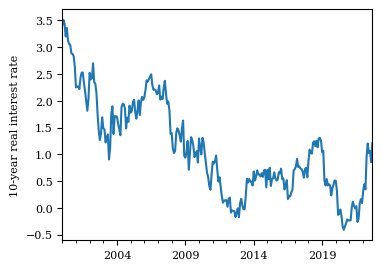

In [5]:
# Plot interest rate time series
series.plot(ylabel='10-year real interest rate')

Other popular time series available on FRED are the [CPI](https://fred.stlouisfed.org/series/CPIAUCSL), [real GDP](https://fred.stlouisfed.org/series/GDPC1) and the [unemployment rate](https://fred.stlouisfed.org/series/UNRATE).

### Yahoo! Finance data

[`yfinance`](https://pypi.org/project/yfinance/) is a user-written library to access data from [Yahoo! Finance](https://finance.yahoo.com/) using the public API (see the project's [GitHub repository](https://github.com/ranaroussi/yfinance) for detailed examples). This project is not affiliated with Yahoo! Finance and is intended for personal use only. Before using the library, it needs to be installed from PyPi as follows:
```
pip install yfinance 
```

In [ ]:
# When running via Google Colab, uncomment and execute the following line
#! pip install yfinance

`yfinance` allows us to retrieve information for a single symbol via properties of the `Ticker` object, or for multiple ticker symbols at once.

*Example: Retrieving data for a single symbol*

We first use the API to retrieve data for a single symbol, in this case the [S&P 500 index](https://finance.yahoo.com/quote/%5EGSPC) which has the (somewhat unusual) ticker symbol `^GSPS`. One can easily find the desired ticker symbol by searching for some stock, index, currency or other asset on Yahoo! Finance.

In [6]:
import yfinance as yf

# Symbol for S&P 500 index
symbol = '^GSPC'

# Create ticker object
ticker = yf.Ticker(symbol)

We can now use the attributes of the `ticker` object to get all sorts of information. For example, we can get some meta data from the `info` attribute as follows:

In [7]:
# Descriptive name and asset class
shortname = ticker.info['shortName']
quoteType = ticker.info['quoteType']

# 52-week low and high
low = ticker.info['fiftyTwoWeekLow']
high = ticker.info['fiftyTwoWeekHigh']

print(f'{shortname} is an {quoteType}')
print(f'{shortname} 52-week range: {low} - {high}')

# To see which keys are available, use the keys() method
# ticker.info.keys()

S&P 500 is an INDEX
S&P 500 52-week range: 3636.87 - 4818.62


We use the `history` attribute to get detailed price data. Unless we want all available data, we should select the relevant period using the `start=...` and `end=...` arguments. 

In [8]:
# Retrieve daily index values data for this year
daily = ticker.history(start='2022-01-01', end='2022-03-31')

# Print first 5 rows
daily.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03,4778.140137,4796.640137,4758.169922,4796.560059,2775190000,0,0
2022-01-04,4804.509766,4818.620117,4774.270020,4793.540039,3641050000,0,0
2022-01-05,4787.990234,4797.700195,4699.439941,4700.580078,3733540000,0,0
2022-01-06,4693.390137,4725.009766,4671.259766,4696.049805,3371250000,0,0
2022-01-07,4697.660156,4707.950195,4662.740234,4677.029785,3279870000,0,0


We can then use this data to plot the daily closing price and trading volume.

(0.0, 10000000000.0)

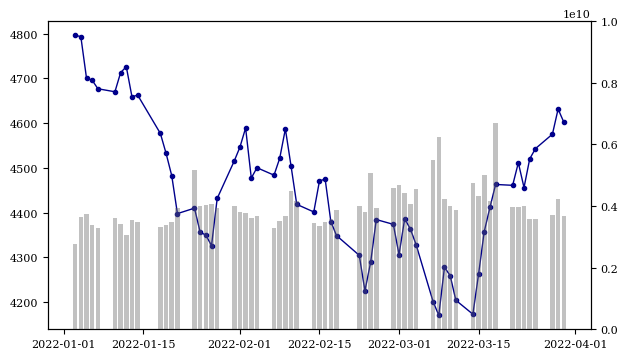

In [9]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1, 1, figsize=(7,4))

# Plot closing price
ax.plot(daily.index, daily['Close'], color='darkblue', marker='o', ms=3, lw=1)

# Create secondary y-axis for trading volume
ax2 = ax.twinx()

# Plot trading volume as bar chart
ax2.bar(daily.index, daily['Volume'], color='#666666', alpha=0.4, zorder=-1, lw=0)
ax2.set_ylim((0.0, 1.0e10))

*Example: Retrieving data for multiple symbols*

We can download trading data for multiple symbols at once using the `download()` function. Unlike the `Ticker` class, this immediately returns a `DataFrame` containing data similar to the `history` method we called previosuly, but now the column index contains an additional level for each ticker symbol. For example, to get the trading data for Amazon and Microsoft for the last 3 months, we proceed as follows:

In [10]:
import yfinance as yf

# Get data for Amazon (AMZN) and Microsoft (MSFT) for the last three months.
# valid intervals for the 'period' argument are: 
#   1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
data = yf.download("AMZN MSFT", period='3mo')
data.head()

[*********************100%***********************]  2 of 2 completed


Adj Close                   Close                    High  \
                  AMZN        MSFT        AMZN        MSFT        AMZN   
Date                                                                     
2022-06-27  113.220001  264.328949  113.220001  264.890015  117.980003   
2022-06-28  107.400002  255.936752  107.400002  256.480011  114.849998   
2022-06-29  108.919998  259.708740  108.919998  260.260010  110.989998   
2022-06-30  106.209999  256.285980  106.209999  256.829987  108.180000   
2022-07-01  109.559998  259.030182  109.559998  259.579987  109.750000   

                               Low                    Open              \
                  MSFT        AMZN        MSFT        AMZN        MSFT   
Date                                                                     
2022-06-27  268.299988  112.699997  263.279999  117.089996  268.209991   
2022-06-28  266.910004  107.040001  256.320007  113.500000  263.980011   
2022-06-29  261.970001  106.910004  255.759995  107.379997  257.589996   
2022-06-30  259.529999  102.519997  252.899994  108.110001  257.049988   
2022-07-01  259.769989  105.849998  254.610001  106.290001  256.390015   

              Volume            
                AMZN      MSFT  
Date                            
2022-06-27  62133200  24615100  
2022-06-28  74942900  27295500  
2022-06-29  66375300  20069800  
2022-06-30  97679400  31730900  
2022-07-01  73021200  22837700

To extract data for a particular symbol, we have to take into account the hierarchical column index:

In [11]:
# Use hierarchical indexing to get data for Amazon
data[('Close', 'AMZN')].head()

Date
2022-06-27    113.220001
2022-06-28    107.400002
2022-06-29    108.919998
2022-06-30    106.209999
2022-07-01    109.559998
Name: (Close, AMZN), dtype: float64

<AxesSubplot:xlabel='Date'>

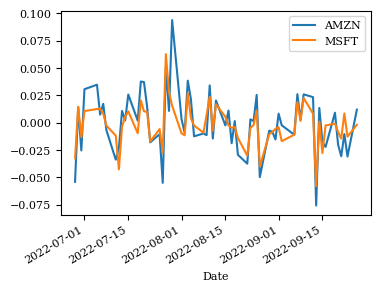

In [12]:
# Plot daily returns for both stocks
returns = data['Close'].diff() / data['Close']
returns.plot(y=['AMZN', 'MSFT'])

### NASDAQ data API (formerly quandl)

The NASDAQ stock exchange provides an open-source Python library hosted on [GitHub](https://github.com/Nasdaq/data-link-python) 
to access various types of financial data (not only those traded on NASDAQ), see [here](https://data.nasdaq.com/) for details. The detailed API documentation can be found at 
[here](https://docs.data.nasdaq.com/docs). This data API was formerly known as [quandl](https://github.com/quandl/quandl-python) which is no longer actively maintained but might still work.

Before using this service, you need to make sure that the Python package is installed. Depending on how you launched this notebook, you may need to execute the following code to install `nasdaq-data-link`:
```
pip install nasdaq-data-link
```

Various types of data are available via this service and can be found using the online search at [https://data.nasdaq.com/search](https://data.nasdaq.com/search).

- Data come from various data provides. To select a data set, you usually have to specify a string of the form `'PROVIDER/SERIES'` where `'PROVIDER'` is the name of the provider (e.g., `'FRED'` or `'BOE'`) and `'SERIES'` is the name of the time series.
- Most of these data require a subscription or at least a free NASDAQ account. Once you have an account, you will need to get an API key and specify it when retrieving data. See the above links for details. 
- Some commercial data series include sample data that can be used without a subscription but requires a free NASDAQ account.
- Some data series are freely available without a subscription or an account. These are often taken from other freely available data sets such as [FRED](https://fred.stlouisfed.org/) or [blockchain.com](https://www.blockchain.com/). We'll be using these to demonstrate how the API works.

  _Important:_ Even for freely available data, NASDAQ imposes a cap of 50 calls per day. You need to register to get around this.

The data is returned as pandas `DataFrame` object (or alternatively as an NumPy array).

In [58]:
# When running via Google Colab, uncomment and execute the following line
#! pip install nasdaq-data-link

*Example: Data from the Bank of England*

Let's start by retrieving some macroeconomic times series from the Bank of England (BOE). It's not always straightforward to find the name of the time series one is looking for, but you can see some of the available time series [here](https://data.nasdaq.com/data/BOE-bank-of-england-official-statistics/documentation). The name will vary depending on the type of data (interest rate, exchange rate), the frequency and how it is aggregated (daily, last day of the month, monthly average) and a currency pair, if applicable.

<AxesSubplot:xlabel='Date', ylabel='5 Year Real Implied Forward (Monthly)'>

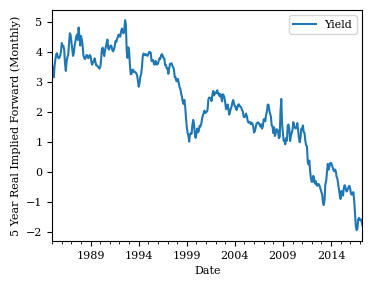

In [59]:
# Retrieve 5-year real implied yield on UK government bonds
import nasdaqdatalink as ndl
df = ndl.get('BOE/IUMASRIF')

# Rename column which is always called 'Value'
df = df.rename(columns={'Value': 'Yield'})

# Plot time series 
df.plot(ylabel='5 Year Real Implied Forward (Monthly)')

As another example, we retrieve the US dollar / Sterling exchange rate at a monthly frequency (this is determined by the name of the time series used where `ML` requests the monthly series, using the last observation for each month). Note that we can pass additional arguments, for example restricting the time period we want to retrieve using `start_date` and `end_date`.

<AxesSubplot:xlabel='Date', ylabel='USD/GBP exchange rate'>

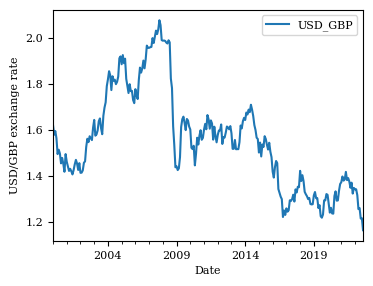

In [60]:
# Get USD / GDP exchange rate using the last observation for each month.
df = ndl.get('BOE/XUMLUSS', start_date='2000-01-31')
df = df.rename(columns={'Value': 'USD_GBP'})

# Plot USD/GBP time series
df.plot(ylabel='USD/GBP exchange rate')

*Example: Data from blockchain.com*

The NASDAQ data link also supports retrieving data on cryptocurrencies. For example, there is a freely accessible time series for the price of Bitcoin in USD.

<AxesSubplot:xlabel='Date', ylabel='BTC price in USD'>

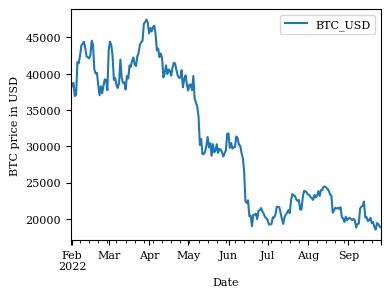

In [61]:
import nasdaqdatalink as ndl

# Retrieve price of BTC in USD for 2022
df = ndl.get('BCHAIN/MKPRU', start_date='2022-01-31')

# Change column name to something more descriptive
df = df.rename(columns={'Value': 'BTC_USD'})

# Plot time series
df.plot(ylabel='BTC price in USD')

*Example: Historical stock data*

As a final example, we obtain the trading data for the stock of Apple (ticker symbol `AAPL`) for the year 2001. Such data is often not available without a subscription or a login, but it works if the requested time period is sufficiently far in the past!

In [62]:
# Retrieve stock data for Apple (ticker symbol AAPL)
df = ndl.get("WIKI/AAPL", start_date='2000-01-01', end_date='2000-12-31')

Unlike in the previous examples, this data contains not only a single value, but a whole range of variables including the opening and closing price, the trading volume, etc.:

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2000-01-03 to 2000-12-29
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         252 non-null    float64
 1   High         252 non-null    float64
 2   Low          252 non-null    float64
 3   Close        252 non-null    float64
 4   Volume       252 non-null    float64
 5   Ex-Dividend  252 non-null    float64
 6   Split Ratio  252 non-null    float64
 7   Adj. Open    252 non-null    float64
 8   Adj. High    252 non-null    float64
 9   Adj. Low     252 non-null    float64
 10  Adj. Close   252 non-null    float64
 11  Adj. Volume  252 non-null    float64
dtypes: float64(12)
memory usage: 25.6 KB


To plot a specific column, we can use the `y=...` argument to `DataFrame.plot()`.

<AxesSubplot:xlabel='Date', ylabel='Stock prive of AAPL'>

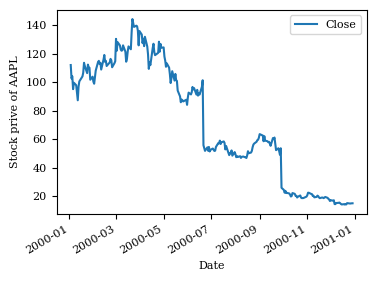

In [64]:
df.plot(y='Close', ylabel='Stock prive of AAPL')

### Pandas Datareader

[`pandas-datareader`](https://github.com/pydata/pandas-datareader) is a Python library that fetches online data from multiple sources and returns them as pandas `DataFrame` objects. Despite its name, this library is not included in `pandas` and may need to be installed separately, e.g., by running
```
pip install pandas-datareader
```

The aim is to provide a uniform API to access data from multiple sources, including those we covered earlier.
See the official [documentation](https://pandas-datareader.readthedocs.io/en/latest/) for supported data sources and how to access them.

In [1]:
# Uncomment and execute the following line if running in Google Colab
# ! pip install pandas-datareader

*Example: Downloading data from FRED*

As a first illustration, we fetch macroeconomic data from [FRED](https://fred.stlouisfed.org/), but instead of `fredapi` we use `pandas-datareader` and set the data source to `'fred'`. No API key is required for this particular data source, but this is not true for all data sources supported by `pandas-datareader`.

Note that we find the name of the series we want to download in the same way as previously discussed in the section on FRED.

In [7]:
# The convention is to import this library as web
import pandas_datareader.data as web

# define start and end dates
start_date = "2000-01-01"
end_date = "2021-12-31"

# Specify series name as first and 'fred' data source as second argument
gdp = web.DataReader('GDP', 'fred', start_date, end_date)

# Show first 3 observations
gdp.head(3)

,GDP
DATE,
2000-01-01,10002.179
2000-04-01,10247.720
2000-07-01,10318.165


We can also fetch multiple series at the same time, for example the CPI and the unemployment rate.

In [10]:
data = web.DataReader(['CPIAUCSL', 'UNRATE'], data_source='fred', start='2020-01-01')
data.head(3)

,CPIAUCSL,UNRATE
DATE,,
2020-01-01,258.682,3.5
2020-02-01,259.007,3.5
2020-03-01,258.165,4.4


*Example: Download data from Yahoo! Finance*

As another example, we can use `pandas-datareader` as a client for Yahoo! Finance by specifying `'yahoo'` as the data source. As with `yfinance` we discussed earlier, we use the search function on 
[Yahoo! Finance](https://finance.yahoo.com)
to identify the ticker symbol for the data series we are interested in.

The example below also illustrates that we can optionally use instances of `datetime` to define the sample period instead of plain strings.

In [15]:
import pandas_datareader.data as web
import datetime

# Instead of strings, we can define period in terms of datetime objects:
# Sample period: 2011-01-1 to 2021-12-31
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2021, 12, 31)

# Fetch stock price data for Tesla (ticker symbol TSLA)
data = web.DataReader('TSLA', data_source='yahoo', start=start, end=end)

data.head(3)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,1.800000,1.726667,1.789333,1.774667,19245000.0,1.774667
2011-01-04,1.796667,1.734667,1.777333,1.778000,17811000.0,1.778000
2011-01-05,1.793333,1.746000,1.765333,1.788667,21700500.0,1.788667


***
## Pickling

A wholly different approach to data I/O is taken by Python's
built-in [`pickle`](https://docs.python.org/3/library/pickle.html)
module.
Almost any Python object can be
dumped into a binary file and read back using `pickle.dump()`
and `pickle.load()`.

The big advantage over other methods
is that hierarchies of objects are automatically supported.
For example, we can pickle a list containing a `tuple`, a string and a NumPy array:

In [65]:
import numpy as np
import pickle
import tempfile
import os.path

# Generate 2d array of integers
arr = np.arange(10).reshape((2, -1))
tpl = (1, 2, 3)
text = 'Pickle is very powerful!'

# data: several nested containers and strings
data = [tpl, text, arr]

# create temporary directory
d = tempfile.TemporaryDirectory()
# Binary destination file
file = os.path.join(d.name, 'data.bin')

# print destination file path
print(f'Pickled data written to {file}')

with open(file, 'wb') as f:
    pickle.dump(data, f)

Pickled data written to /tmp/tmpjwzpy3a6/data.bin


We can then read back the data as follows:

In [66]:
# load pickle data from above
with open(file, 'rb') as f:
    data = pickle.load(f)

# expand data into its components
tpl, text, arr = data
arr         # prints previously generated 2d array

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

The above example introduces a few concepts we have not encountered so far:

1.  The built-in function 
    [`open()`](https://docs.python.org/3/library/functions.html#open)
    is used to open files for reading or writing.

    -   The second argument indicates whether
        a file should be read-only, `r`, or writeable, `w`.
    -   The `b` sets the file mode to *binary*, i.e., its contents are *not*
        human-readable text.

2.  We usually access files using a so-called *context manager*.
    A context manager is created via the `with` statement.

    A big advantage of using a context manager is that the
    file resource made available as `f` in the block following
    `with` is automatically cleaned up as soon as the block exits.
    This is particularly important when writing data.

So why not always use `pickle` to load and store data?

1.  Pickling is Python-specific and no other application can process
    pickled data.
2.  The pickle protocol can change in a newer version of Python,
    and you might not be able to read back your old pickled objects.
3.  Even worse, because projects such as NumPy and pandas implement
    their own pickling routines, you might not even be able
    to unpickle old DataFrames when you upgrade to a newer pandas version!
4.  `pickle` is not secure: It is possible to construct binary
    data that will execute arbitrary code when unpickling, so you
    don't want to unpickle data from untrusted sources.
5.  Some objects cannot be pickled automatically.
    For example, this applies to
    any classes defined with Numba or Cython, unless special care
    is taken to implement the pickle protocol.


`pickle` is great for internal use when you do not need to exchange
data with others and have complete control over your computing environment
(i.e., you can enforce a specific version of Python and the libraries you are
using). For anything else, you should avoid it.